# Homework 6
This homework builds on the effective visualization workshop with the Star Trek data. Below is what we completed in class. Output is suppressed for readability, but you can remove the supression on your code if you'd like.

In [1]:
invisible({
suppressPackageStartupMessages(library(tidyverse))

# Get the data.
dialogs <- read_csv(
  "https://raw.githubusercontent.com/Vincent-Toups/bios512/fcbc65a2696c7cff80d0f6ed1dd5c97abf0ef800/effective-visualization/source_data/tng.csv",
  show_col_types = FALSE
)
head(dialogs, 10) # Showing first 10 observations

# Checkout the data.
names(dialogs)
dialogs %>% group_by(character) %>% tally() %>% arrange(desc(n))
dialogs %>% mutate(dialog_length=str_length(dialog)) %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length)) %>% arrange(desc(mean_dialog_length))

# Fix weird data.
dialogs %>% filter(character=="BEVERLY'S")

dialogs_fixed <- dialogs %>%
  mutate(
    character = str_replace_all(character, "'S.*$", ""),
    character = str_replace_all(character, " VOICE", ""),
    character = str_replace_all(character, "\\.", ""),
    character = str_replace_all(character, "'", ""),
    character = str_replace_all(character, "S COM", ""),
    character = str_replace_all(character, " COM", ""),
    dialog_length = str_length(dialog)
  ) %>%
  filter(character %in% unlist(str_split("PICARD RIKER DATA TROI BEVERLY WORF WESLEY GEORDI", " ")))

dialogs_fixed %>% group_by(character) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length)) %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep <- dialogs_fixed %>% group_by(character, episode_number) %>% summarize(mean_dialog_length = mean(dialog_length), std_dialog_length=sd(dialog_length), .groups = "drop") %>% arrange(desc(mean_dialog_length))

dialog_len_per_ep

# Plot the data.
ggplot(dialogs_fixed) + geom_density(aes(x=dialog_length))

for_factor <- dialog_len_per_ep %>% group_by(character) %>% summarise(m=mean(mean_dialog_length)) %>% arrange(desc(m))
ggplot(dialog_len_per_ep, aes(factor(character,for_factor$character), mean_dialog_length)) + geom_boxplot()

dialog_len_per_ep <- dialogs_fixed %>%
    group_by(character, episode_number) %>%
    summarize(mean_dialog_length = mean(dialog_length), dialog_count=n(), .groups = "drop") %>%
    arrange(desc(mean_dialog_length))

ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) + geom_point(aes(color=character)) + facet_wrap(~character)
})

## Question 1
In class, we left off on the plot below, which shows the distribution of dialog count by mean dialog length, where each point represents an episode. Interpret these results. How can we tell the character's role in the story by their plot?

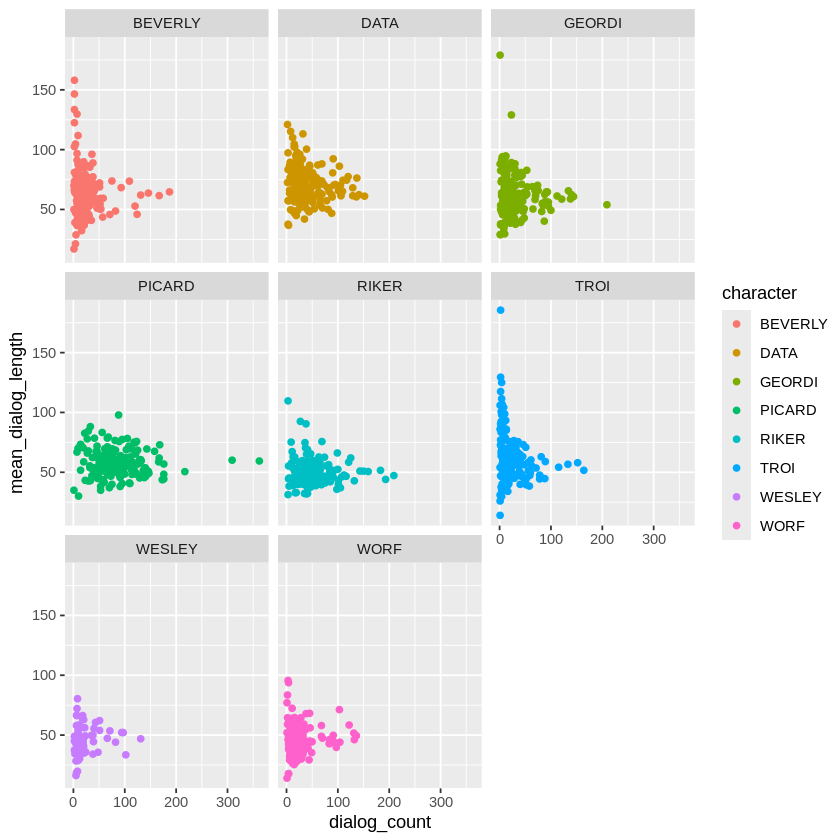

In [2]:
ggplot(dialog_len_per_ep, aes(dialog_count, mean_dialog_length)) +
    geom_point(aes(color=character)) +
    facet_wrap(~character)

I noticed that most of the characters' dialogue count don't exceed 200 per episode, with a few exceptions for Picard and Geordi. Picard seems to be a main protagonist in the show because his dialog is fast-paced, and yet very frequent. We see that for Beverly, Geordi, and Troi, in one episode their mean dialogue length is exceeding 150, which is comparatively long - perhaps they are the center of the plot in those episodes.

## Question 2
#### a) Compare Beverly's mean dialog per episode vs. mean dialog count per episode from season 1 (episodes 102-126) to season 3 (episodes 149-174) in a table.  
*Hints*:  
-   First, use `filter()` to get - 1) the dialog from only Beverly's character and 2) the episodes within the ranges given.
-   Then, add a season variable using `mutate()` with `case_when()`.
-   To create the means per episode, after your `mutate()` step, you'll need to `group_by()` season and episode number, then you can do your `summarize()` step to get the means by episode. At the end of the `summary()` statement (inside the parenthesis), add `.groups="drop"`.
-   Then, to get the mean of means, you'll do the same as above, but only grouping by season.

In [3]:
beverly <- dialog_len_per_ep |>
  filter(character == "BEVERLY", episode_number >= 102, episode_number <= 174) |>
  mutate(season = case_when(episode_number <= 126 ~ "Season 1", episode_number >= 149 ~ "Season 3"))

beverly_means <- beverly |>
group_by(season, episode_number) |>
summarize(
dialog_count = sum(dialog_count),
mean_length = mean(mean_dialog_length),
.groups = "drop"
)

mean_of_means <- beverly_means |>
group_by(season) |>
summarize(
mean_dialog_count = mean(dialog_count),
mean_dialog_length = mean(mean_length),
.groups = "drop"
)

mean_of_means

season,mean_dialog_count,mean_dialog_length
<chr>,<dbl>,<dbl>
Season 1,25.40,56.48460
Season 3,19.64,67.04817
NA,15.00,35.73333


#### b) In class, we talked about this character saying the actress has stated that after she was fired and rehired, the writers began giving her storylines that made her feel like a male character. How is this reflected in our table?

In season 3, we see that the actress has a decreased mean dialog count but increased mean dialog length compared to before. It is possible that male characters are often given lengtheir dialogs.

## Question 3
Let's compare the vocabulary richness (unique words / total words) of each character.
#### a) Tokenize dialog into words, remove punctuation, convert to lowercase. Then filter out the stop words in the list below (from https://gist.github.com/sebleier/554280).
*Hint*: Here's a template for that this step should look like:
```
tokens <- YOUR_DATASET %>%
  # Split each dialog into words
  mutate(word_list = str_split(DIALOG_COLUMN, "\\s+")) %>%
  
  # Unnest the list column so each word is a row
  unnest(word_list) %>%
  
  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%
  
  # Remove empty strings and stopwords
  filter(word != "", !word %in% STOPWORDS)
```

In [4]:
stop_words <- c(
  "i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself",
  "yourselves","he","him","his","himself","she","her","hers","herself","it","its","itself",
  "they","them","their","theirs","themselves","what","which","who","whom","this","that",
  "these","those","am","is","are","was","were","be","been","being","have","has","had",
  "having","do","does","did","doing","a","an","the","and","but","if","or","because","as",
  "until","while","of","at","by","for","with","about","against","between","into","through",
  "during","before","after","above","below","to","from","up","down","in","out","on","off",
  "over","under","again","further","then","once","here","there","when","where","why","how",
  "all","any","both","each","few","more","most","other","some","such","no","nor","not",
  "only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
)

In [5]:
tokens <- dialogs_fixed %>%
  # Split each dialog into words
  mutate(word_list = str_split(dialog, "\\s+")) %>%

  # Unnest the list column so each word is a row
  unnest(word_list) %>%

  # Clean words
  mutate(
    word = str_remove_all(word_list, "[[:punct:]]"),  # Remove punctuation
    word = str_to_lower(word)                         # Convert to lowercase
  ) %>%

  # Remove empty strings and stopwords
  filter(word != "", !word %in% stop_words)

#### b) Count unique words per character. Print a summary table with the following columns: character, total words, unique words, and vocabulary richness.  
*Hint*: Group by character, then use `summarize()` to get what you want. You'll use `n_distinct()` to get the unique word counts. Arrange in descending value of vocabulary richness.

In [6]:
vocab_summary <- tokens |>
group_by(character) |>
summarize(
total_words = n(),
unique_words = n_distinct(word),
vocabulary_richness = unique_words / total_words,
.groups = "drop"
) |>
arrange(desc(vocabulary_richness))
vocab_summary

character,total_words,unique_words,vocabulary_richness
<chr>,<int>,<int>,<dbl>
WESLEY,7601,2291,0.3014077
WORF,18820,4318,0.2294368
TROI,19450,4187,0.2152699
BEVERLY,22900,4875,0.2128821
DATA,45462,8593,0.1890150
GEORDI,31978,5465,0.1708987
RIKER,41827,6458,0.1543979
PICARD,79214,9272,0.1170500


#### c) Plot total words versus vocab richness.
-   Use the character names as the "points".
    -   *Hint*: Use `geom_text()` to add the character names as the points.
-   Do not include a legend.
    -   *Hint*: Use `theme()` to remove the legend.
-   Add a title and axis titles.
    -   *Hint*: Use `labs()` to add titles.

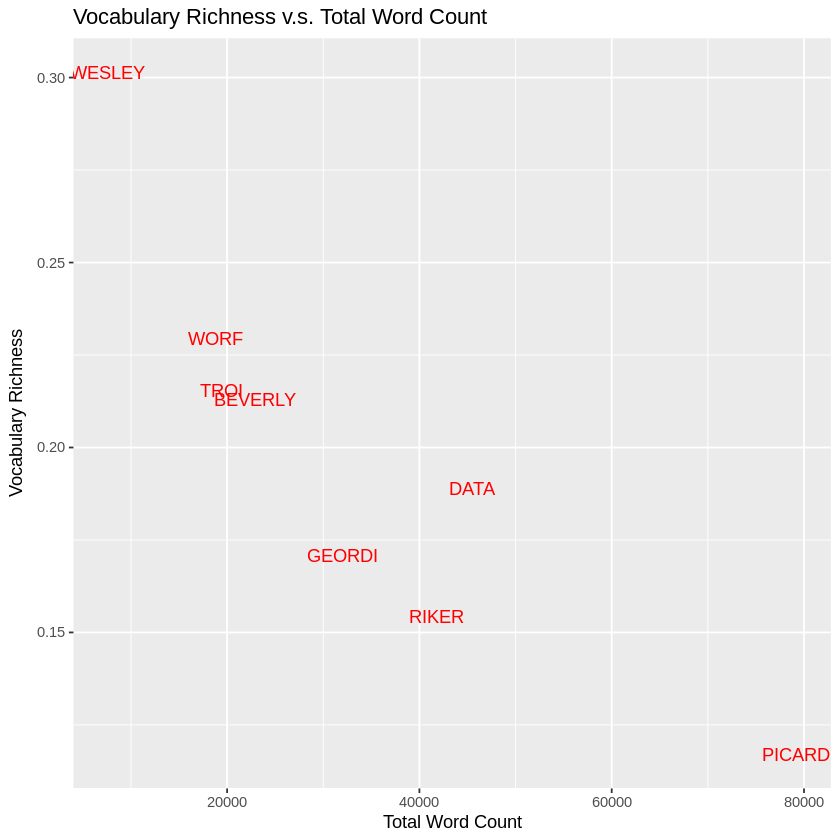

In [7]:
ggplot(vocab_summary, aes(x = total_words, y = vocabulary_richness, label = character)) +
geom_text(color = "red")+
labs(
  title = "Vocabulary Richness v.s. Total Word Count",
  x = "Total Word Count",
  y = "Vocabulary Richness") +
theme(legend.position = "none")

#### d) Interpret these results.

These results show an inverse relationship between the characters' total word count and vocabulary richness. While Picard speaks a lot, the uniqueness of the character's words spoken are very low, meaning there is a lot of overlap in their line. In comparsion, on the opposite of the spectrum is Wesley, who doesn't have a lot of total words spoken, but whose words are highly unique.

## Question 4
#### a) Find what episode Wesley left the show as a main character and state it explicitly. Meaning, find the first significant gap where he is not found in more than two episodes in a row.
*Hint*: It's after season 3 (ended at episode 174), so you can filter out seasons 1-3 and print Wesley's dialog count per episode. Then, scan the table for the gap.

In [8]:
Wesley <- dialogs_fixed |>
filter(character == "WESLEY", episode_number > 174) |>
group_by(episode_number) |>
summarize(
dialog_count = n(),
.groups = "drop")
Wesley

episode_number,dialog_count
<dbl>,<int>
175,18
176,6
177,9
178,6
179,38
181,2
183,94
206,131
219,71


There is a significant gap between episode 183 and 206, meaning that Wesley likely left the show after episode 183.

#### b) After Wesley leaves the main cast, in which episodes does he make cameo appearances?

Wesley makes cameo appearances in episodes 206, 219, 263, and 272.

#### c) Dig back into the data. Print:
-   Wesley's last piece of dialog before he left the main cast.
-   Wesley's last piece of dialog ever.  
  
*Hint*: To do this, you'll need to filter the `dialogs_fixed` data set to Welsey's lines and the episode number, and use `slice_tail(n = 1)` to get the last observation.

In [9]:
wesley_last_main_cast <- dialogs_fixed |>
filter(character == "WESLEY", episode_number == 183) |>
slice_tail(n = 1) |>
select(dialog)

wesley_last_ever <- dialogs_fixed |>
filter(character == "WESLEY") |>
slice_tail(n = 1) |>
select(dialog)

wesley_last_main_cast
wesley_last_ever

dialog
<chr>
I can walk.


dialog
<chr>
"Good-bye, Mom."


Wesley's last piece of dialog before he left the main cast is "I can walk".
Wesley's last piece of dialog ever is "Good-bye, Mom".

## Question 5
Create a heatmap with `dialog_len_per_ep` showing mean dialog length per episode for each character. Sort the characters on the y-axis by their overall mean dialog length, with the lowest on top using a factor. Add a title and an axis title.
*Hints*:
For the factor:
1. Compute overall mean (mean of mean) dialog length per character (`group_by()` then `summarize()`), and arrange the overall mean in ascending order. Add `pull(character)` to the end of this step so that you can use character as a factor in the next step. Store all of this in a new tibble.
2. Convert character to factor with this order. On `dialog_len_per_ep`, you'll use a mutate statement to add the factor `(mutate(character = factor(character, levels = DATAFROMHINT1))`.
3. Create heatmap using `geom_tile()`.
4. If you want nicer colors, you can add `scale_fill_viridis_c()` (or another color scale) to your ggplot statement. **Not required**, but fun to mess around with!

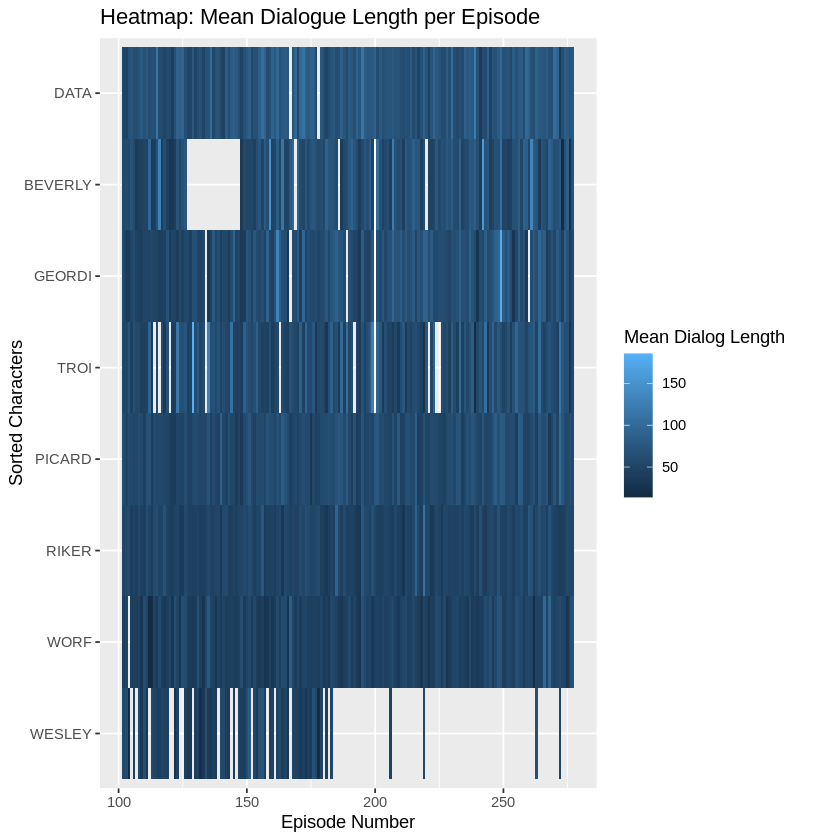

In [10]:
character_overall_mean <- dialog_len_per_ep |>
group_by(character)|>
summarize(
mean_of_means = mean(mean_dialog_length),
.groups = "drop"
) |>
arrange(mean_of_means) |>
pull(character)

dialog_len_per_ep <- dialog_len_per_ep |>
mutate(character = factor(character, levels = character_overall_mean))

ggplot(dialog_len_per_ep, aes(x = episode_number, y = character)) +
geom_tile(aes(fill = mean_dialog_length)) +
labs(
title = "Heatmap: Mean Dialogue Length per Episode",
x = "Episode Number",
y = "Sorted Characters",
fill = "Mean Dialog Length"
)